In [89]:
import preprocessing
import os
import math
import dlib
import matplotlib.pyplot as plt

In [90]:
train_frame_folders = [
    '../../../archive/original_sequences/youtube/c23/videos/'
]

In [76]:
detector = dlib.get_frontal_face_detector()

train_date_azi_vectors = []

for train_frame_folder in train_frame_folders:
    list_of_train_data = [f for f in os.listdir(
        train_frame_folder) if f.endswith('.mp4')]
    print(train_frame_folder, 'videos: ', len(list_of_train_data))
    for i, vid in enumerate(list_of_train_data):
        print("Video {}/{}".format(i + 1, len(list_of_train_data)))
        if i == 20:
            print("finish")
            break
        # video frames vectors
        frames_vectors = []

        # Video capturing constructor.
        cap = cv2.VideoCapture(os.path.join(train_frame_folder, vid))

        # Returns true if video capturing has been initialized already.
        while cap.isOpened():
            # read the video frame by frame
            ret, frame = cap.read()
            if ret != True:
                break

            face_rects, scores, idx = detector.run(frame, 0)
            for i, d in enumerate(face_rects):
                x1 = d.left()
                y1 = d.top()
                x2 = d.right()
                y2 = d.bottom()

                crop_img = frame[y1:y2, x1:x2]
                if crop_img is not None and crop_img.size > 0:
                    crop_img = cv2.resize(crop_img, (128, 128))
                    # calculate dft of an image
                    image_dft = dft(crop_img)

                    # calculate azimuthal integration line
                    azi_line = azimuthal_integration(image_dft)

                    frames_vectors.append(azi_line)
                    break
        
        # get an average for frames vectors
        train_date_azi_vectors.append(np.array(frames_vectors).mean(axis=0))

../../../archive/original_sequences/youtube/c23/videos/ videos:  1000
Video 1/1000
Video 2/1000
Video 3/1000
Video 4/1000
Video 5/1000
Video 6/1000
Video 7/1000
Video 8/1000
Video 9/1000
Video 10/1000
Video 11/1000
Video 12/1000
Video 13/1000
Video 14/1000
Video 15/1000
Video 16/1000
Video 17/1000
Video 18/1000
Video 19/1000
Video 20/1000
Video 21/1000
finish


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


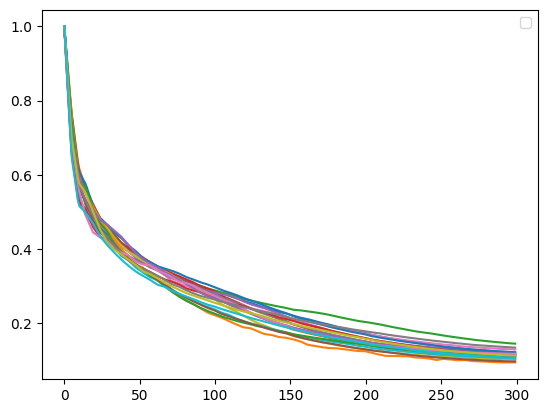

In [77]:
x1 = np.arange(300)

for p in train_date_azi_vectors:
    plt.plot(x1, p)
plt.legend()
plt.show()

In [78]:
from sklearn.decomposition import PCA

In [83]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(train_date_azi_vectors)

In [84]:
# tsne = TSNE(n_components=2, verbose=1, perplexity=2, n_iter=4000)
# point1 = tsne.fit_transform(np.array(train_date_azi_vectors))

(20, 2)


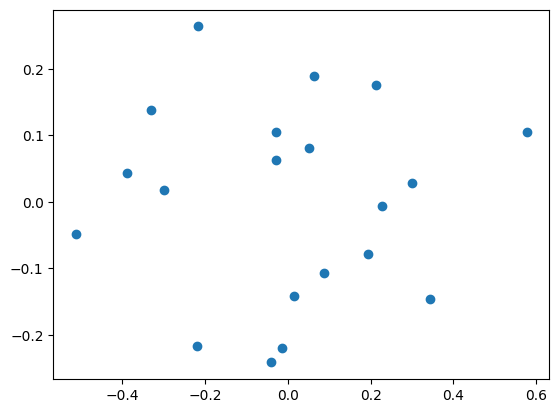

In [85]:
print(pca_result.shape)
plt.scatter(pca_result[:, 0], pca_result[:, 1])
plt.show()
# point2 = tsne.fit(train_date_azi_vectors[0].reshape((1, -1)))
# print(point2)